In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/EXCL.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,2.393792,2.327897,2.269292,1.138244,1.200055,1.162808,1.110837,0.195354,0.478070,0.710854,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,2.732008
2012-10-18,2.430647,2.355021,2.287182,1.896593,1.200055,1.162808,1.110837,0.507998,0.385900,0.662926,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,2.732008
2012-10-19,2.476715,2.379885,2.303582,1.945187,1.361501,1.315222,1.240480,0.909952,0.434740,0.691659,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,2.799177
2012-10-22,2.531997,2.407010,2.322962,1.766551,0.407668,0.685853,0.772045,-0.092802,-0.063191,0.026328,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,2.664839
2012-10-23,2.564244,2.427353,2.336380,0.781027,0.064289,0.417951,0.561367,-0.358124,-0.231107,0.047837,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,2.597670


### Plot the Close price - our target

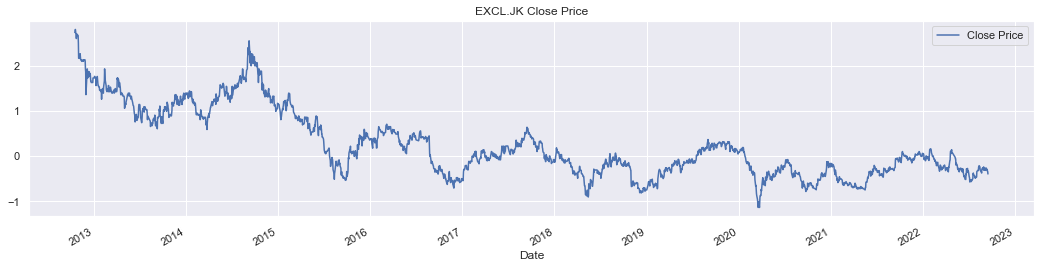

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('EXCL.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

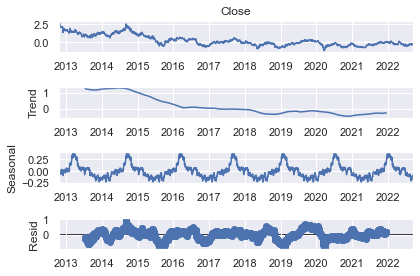

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price


In [10]:
# """
# The Close price is not stationary. 
# Therefore, differencing needs to be performed
# """
# test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


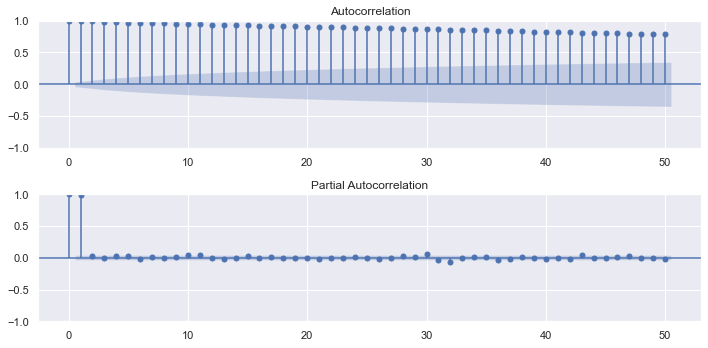

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=0, start_q=0, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[5] intercept   : AIC=-2165.097, Time=1.13 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-2151.766, Time=0.26 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-4385.038, Time=1.12 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-3353.864, Time=0.97 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-2146.806, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-3907.102, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-4593.039, Time=1.95 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=5.67 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.66 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-2165.199, Time=0.70 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-4593.104, Time=2.42 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-4387.515, Time=1.41 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                2302.854
Date:                           Wed, 23 Nov 2022   AIC                          -4593.708
Time:                                   20:21:55   BIC                          -4560.218
Sample:                                        0   HQIC                         -4581.399
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9178      0.017     54.709      0.000       0.885       0.951
ar.L2         -0.0026      0.023     -0.113      0.910      -0.048       0.043
ar.L3         -0.0324      0.018     -1.796      0.072      -0.068       0.003
ar.S.L5       -0.6459      0.020    -31.981      0.000      -0.685      -0.606
ar.S.L10      -0.3260      0.020    -16.450      0.000      -0.365      -0.287
sigma2         0.0056      0.000     48.762      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               772.21
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

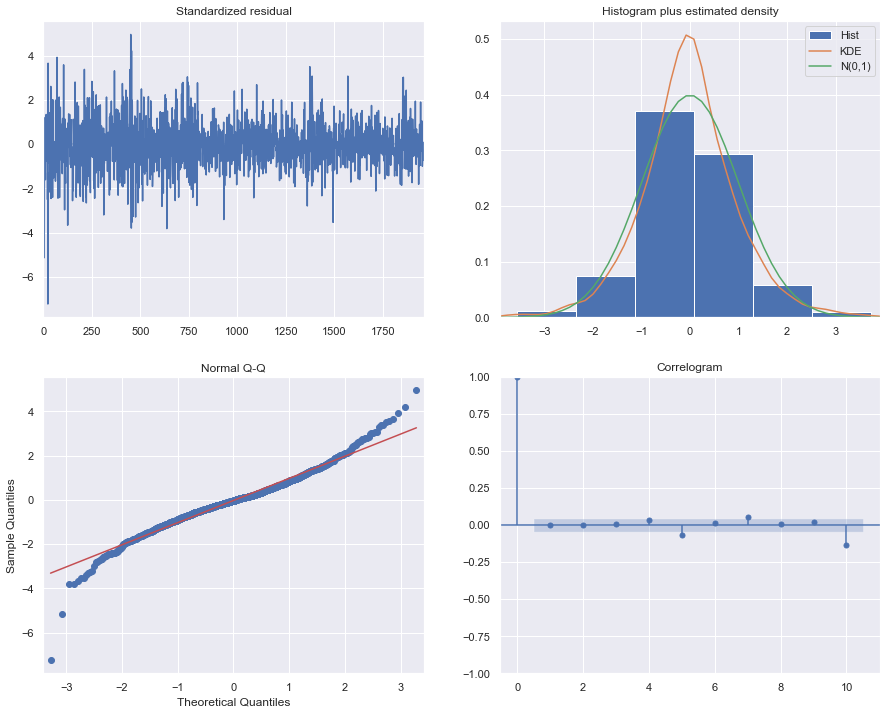

In [15]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,0), seasonal_order=(2,1,0,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4599.717
Date:                           Wed, 23 Nov 2022   AIC                          -9153.434
Time:                                   20:23:00   BIC                          -9025.055
Sample:                                        0   HQIC                         -9106.250
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.0361      0.024      1.517      0.129      -0.011       0.083
14 DAYS MA         0.0236      0.047      0.504      0.614      -0.068       0.115
21 DAYS MA         0.4088      0.049      8.269      0.000       0.312       0.506
7 DAYS STD DEV     0.0006      0.001      0.703      0.482      -0.001       0.002
RSI 7              0.0813      0.011      7.504      0.000       0.060       0.103
RSI 14            -0.5606      0.040    -13.923      0.000      -0.639      -0.482
RSI 21             0.8515      0.034     24.810      0.000       0.784       0.919
MFI 7              0.0033      0.002      1.751      0.080      -0.000       0.007
MFI 14            -0.0008      0.002     -0.332      0.740      -0.005       0.004
MFI 21            -0.0058      0.002     -2.424      0.015      -0.010      -0.001
dayofweek         -0.0003      0.001     -0.272      0.786      -0.002       0.002
quarter            0.0068      0.011      0.621      0.535      -0.015       0.028
month             -0.1113      0.429     -0.259      0.795      -0.953       0.730
year              -0.6479      0.452     -1.434      0.151      -1.533       0.237
dayofyear          0.0454      0.431      0.105      0.916      -0.800       0.891
dayofmonth        -0.0092      0.035     -0.261      0.794      -0.078       0.060
weekofyear        -0.0055      0.005     -1.121      0.262      -0.015       0.004
ar.L1              0.7143      0.017     42.128      0.000       0.681       0.748
ar.L2              0.0660      0.020      3.268      0.001       0.026       0.106
ar.L3              0.0705      0.015      4.553      0.000       0.040       0.101
ar.S.L5           -0.6732      0.018    -37.876      0.000      -0.708      -0.638
ar.S.L10          -0.2691      0.018    -14.680      0.000      -0.305      -0.233
sigma2             0.0005   1.09e-05     48.776      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  88.36   Jarque-Bera (JB):              6927.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [20]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [22]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [23]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.726049,-0.715005
2020-09-11,-0.587646,-0.612861
2020-09-14,-0.511690,-0.558385
2020-09-15,-0.562711,-0.606052
2020-09-16,-0.613466,-0.653719
...,...,...
2022-09-12,-0.390655,-0.306431
2022-09-13,-0.381550,-0.299621
2022-09-14,-0.445039,-0.340478


<AxesSubplot:xlabel='Date'>

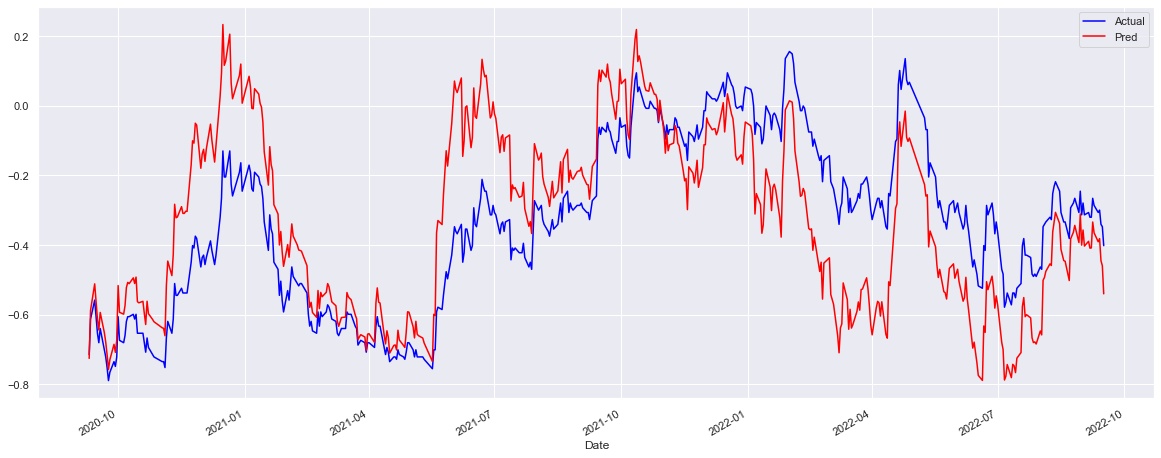

In [24]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [25]:
from joblib import load

In [26]:
close_scaler = load('../feature_engineering/excl_close_scaler.bin')

In [27]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [28]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2023.781093,2040.0
2020-09-11,2227.028527,2190.0


**Plot Error Distribution**

In [29]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

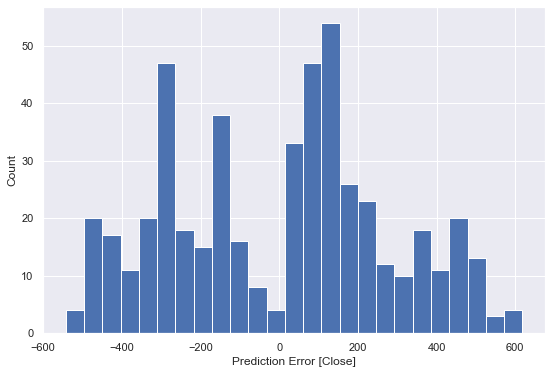

In [30]:
plt.figure(figsize=(9,6))
plotErrorHist(inversed)

**RMSE**

In [31]:
from statsmodels.tools.eval_measures import rmse

In [32]:
rmse(inversed['Pred'], inversed['Actual'])

278.53035492656693

**MAPE**

In [33]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [34]:
mape(inversed['Actual'], inversed['Pred'])

9.128492558392557

**R-squared**

In [35]:
from sklearn.metrics import r2_score

In [36]:
r2_score(inversed['Actual'], inversed['Pred'])

0.35653980687699516

### Save the model

In [37]:
from joblib import dump, load
dump(results, './models/excl.joblib') 

['./models/excl.joblib']

In [38]:
loaded = load('./models/excl.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4599.717
Date:                           Wed, 23 Nov 2022   AIC                          -9153.434
Time:                                   20:24:08   BIC                          -9025.055
Sample:                                        0   HQIC                         -9106.250
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.0361      0.024      1.517      0.129      -0.011       0.083
14 DAYS MA         0.0236      0.047      0.504      0.614      -0.068       0.115
21 DAYS MA         0.4088      0.049      8.269      0.000       0.312       0.506
7 DAYS STD DEV     0.0006      0.001      0.703      0.482      -0.001       0.002
RSI 7              0.0813      0.011      7.504      0.000       0.060       0.103
RSI 14            -0.5606      0.040    -13.923      0.000      -0.639      -0.482
RSI 21             0.8515      0.034     24.810      0.000       0.784       0.919
MFI 7              0.0033      0.002      1.751      0.080      -0.000       0.007
MFI 14            -0.0008      0.002     -0.332      0.740      -0.005       0.004
MFI 21            -0.0058      0.002     -2.424      0.015      -0.010      -0.001
dayofweek         -0.0003      0.001     -0.272      0.786      -0.002       0.002
quarter            0.0068      0.011      0.621      0.535      -0.015       0.028
month             -0.1113      0.429     -0.259      0.795      -0.953       0.730
year              -0.6479      0.452     -1.434      0.151      -1.533       0.237
dayofyear          0.0454      0.431      0.105      0.916      -0.800       0.891
dayofmonth        -0.0092      0.035     -0.261      0.794      -0.078       0.060
weekofyear        -0.0055      0.005     -1.121      0.262      -0.015       0.004
ar.L1              0.7143      0.017     42.128      0.000       0.681       0.748
ar.L2              0.0660      0.020      3.268      0.001       0.026       0.106
ar.L3              0.0705      0.015      4.553      0.000       0.040       0.101
ar.S.L5           -0.6732      0.018    -37.876      0.000      -0.708      -0.638
ar.S.L10          -0.2691      0.018    -14.680      0.000      -0.305      -0.233
sigma2             0.0005   1.09e-05     48.776      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  88.36   Jarque-Bera (JB):              6927.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""